In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import scipy
import math
import pandas_ta as ta
import scipy.stats
import scipy.signal

def find_levels( 
    price: np.array, atr: float, # Log closing price, and log atr 
    first_w: float = 0.1, 
    atr_mult: float = 3.0, 
    prom_thresh: float = 0.1
  ):

    # Setup weights
    last_w = 1.0
    w_step = (last_w - first_w) / len(price)
    weights = first_w + np.arange(len(price)) * w_step
    weights[weights < 0] = 0.0

    # Get kernel of price. 
    kernal = scipy.stats.gaussian_kde(price, bw_method=atr*atr_mult, weights=weights)

    # Construct market profile
    min_v = np.min(price)
    max_v = np.max(price)
    step = (max_v - min_v) / 100 #200
    price_range = np.arange(min_v, max_v, step)
    pdf = kernal(price_range) # Market profile

    # Find significant peaks in the market profile
    pdf_max = np.max(pdf)
    prom_min = pdf_max * prom_thresh

    peaks, props = scipy.signal.find_peaks(pdf, prominence=prom_min)
    levels = [] 
    for peak in peaks:
        levels.append(np.exp(price_range[peak]))

    return levels, peaks, props, price_range, pdf, weights


def support_resistance_levels(
  data: pd.DataFrame, lookback: int, 
  first_w: float = 0.01, atr_mult:float=3.0, prom_thresh:float =0.25
):
    # Get log average true range, 
    atr = ta.atr(np.log(data['high']), np.log(data['low']), np.log(data['close']), lookback)

    all_levels = [None] * len(data)
    for i in range(lookback, len(data)):
        i_start  = i - lookback
        vals = np.log(data.iloc[i_start+1: i+1]['close'].to_numpy())
        levels, peaks, props, price_range, pdf, weights= find_levels(vals, atr.iloc[i], first_w, atr_mult, prom_thresh)
        all_levels[i] = levels

    return all_levels

def sr_penetration_signal(data: pd.DataFrame, levels: list):
    print(levels)
    signal = np.zeros(len(data))
    curr_sig = 0.0
    close_arr = data['close'].to_numpy()
    for i in range(1, len(data)):
        if levels[i] is None:
            continue

        last_c = close_arr[i - 1]
        curr_c = close_arr[i]
        
        for level in levels[i]:
            if curr_c > level and last_c <= level: # Close cross above line
                curr_sig = 1.0
            elif curr_c < level and last_c >= level: # Close cross below line
                curr_sig = -1.0

        signal[i] = curr_sig
    return signal

def get_trades_from_signal(data: pd.DataFrame, signal: np.array):
    long_trades = []
    short_trades = []

    close_arr = data['close'].to_numpy()
    last_sig = 0.0
    open_trade = None
    idx = data.index
    for i in range(len(data)):
        if signal[i] == 1.0 and last_sig != 1.0: # Long entry
            if open_trade is not None:
                open_trade[2] = idx[i] 
                open_trade[3] = close_arr[i]
                short_trades.append(open_trade)

            open_trade = [idx[i], close_arr[i], -1, np.nan]
        if signal[i] == -1.0  and last_sig != -1.0: # Short entry
            if open_trade is not None:
                open_trade[2] = idx[i] 
                open_trade[3] = close_arr[i]
                long_trades.append(open_trade)

            open_trade = [idx[i], close_arr[i], -1, np.nan]

        last_sig = signal[i]

    long_trades = pd.DataFrame(long_trades, columns=['entry_time', 'entry_price', 'exit_time', 'exit_price'])
    short_trades = pd.DataFrame(short_trades, columns=['entry_time', 'entry_price', 'exit_time', 'exit_price'])

    long_trades['percent'] = (long_trades['exit_price'] - long_trades['entry_price']) / long_trades['entry_price'] 
    short_trades['percent'] = -1 * (short_trades['exit_price'] - short_trades['entry_price']) / short_trades['entry_price']
    long_trades = long_trades.set_index('entry_time')
    short_trades = short_trades.set_index('entry_time')
    return long_trades, short_trades 

def analyzeTrades(trades):
  trades['cumulative_profits'] = (1 + trades['percent']).cumprod() - 1
  print(trades)
  # print(total_profit)
  return trades

In [2]:
# Trend following strategy
data = pd.read_csv('../../data/bnb21.csv').tail(1000)
data = data.iloc[::-1]
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, Non

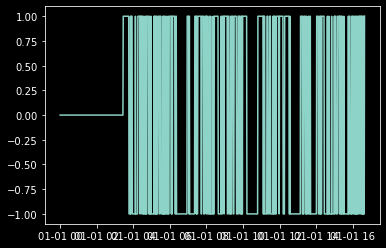

In [3]:
plt.style.use('dark_background')
levels = support_resistance_levels(data, int(len(data)/5), first_w=1.0, atr_mult=3.0)

data['sr_signal'] = sr_penetration_signal(data, levels)
data['log_ret'] = np.log(data['close']).diff().shift(-1)
data['sr_return'] = data['sr_signal'] * data['log_ret']

long_trades, short_trades = get_trades_from_signal(data, data['sr_signal'].to_numpy())

plt.plot(data['sr_signal'])
# plt.plot(data['supp'])
# plt.plot(data['ress'])
# plt.plot(data['close'])
# plt.show()

In [4]:
atrades = analyzeTrades(pd.concat([long_trades, short_trades]).sort_index())

                     entry_price           exit_time  exit_price   percent  \
entry_time                                                                   
2021-01-01 03:27:00      37.9953 2021-01-01 03:46:00     38.0973  0.002685   
2021-01-01 03:46:00      38.0973 2021-01-01 03:51:00     38.0567  0.001066   
2021-01-01 03:51:00      38.0567 2021-01-01 03:52:00     38.0525 -0.000110   
2021-01-01 03:52:00      38.0525 2021-01-01 03:53:00     38.1263 -0.001939   
2021-01-01 03:53:00      38.1263 2021-01-01 03:57:00     38.0584 -0.001781   
...                          ...                 ...         ...       ...   
2021-01-01 16:32:00      38.3324 2021-01-01 16:34:00     38.3556 -0.000605   
2021-01-01 16:34:00      38.3556 2021-01-01 16:35:00     38.3078 -0.001246   
2021-01-01 16:35:00      38.3078 2021-01-01 16:37:00     38.3430 -0.000919   
2021-01-01 16:37:00      38.3430 2021-01-01 16:38:00     38.3373 -0.000149   
2021-01-01 16:38:00      38.3373 2021-01-01 16:39:00     38.3693

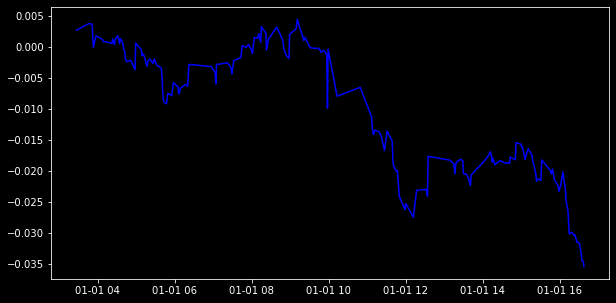

In [5]:
cprofit = plt.figure(figsize=(10,5))
plt.plot(atrades.index, atrades['cumulative_profits'], color='blue', label='Cumulative Profits')
plt.show(cprofit)